Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

/home/nata/programs/jupyter/finalprojectenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3397: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  exec(code_obj, self.user_global_ns, self.user_ns)


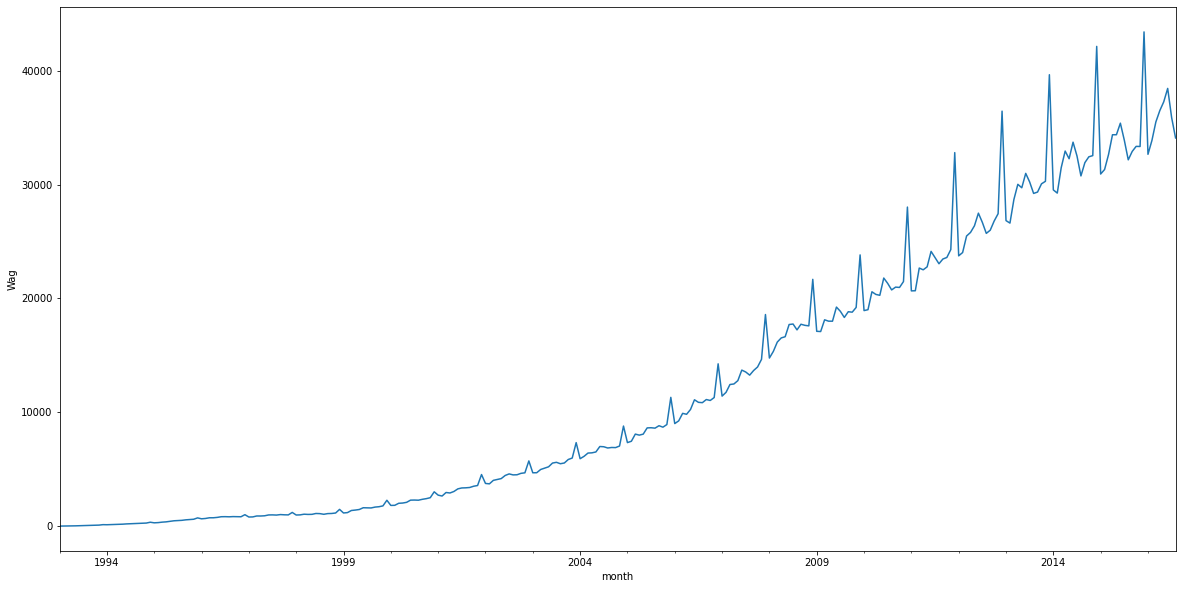

In [32]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
    
    
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))


wag = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize = (20,10))
wag.WAG_C_M.plot()
plt.ylabel('Wag')
plt.show()

Проверка стационарности и STL-декомпозиция ряда:


Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

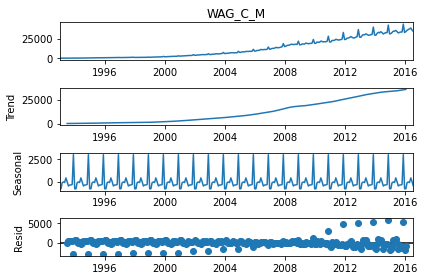

In [33]:
plt.figure(figsize = (15,10))
sm.tsa.seasonal_decompose(wag.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag.WAG_C_M)[1])

ряд нестационарный

Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


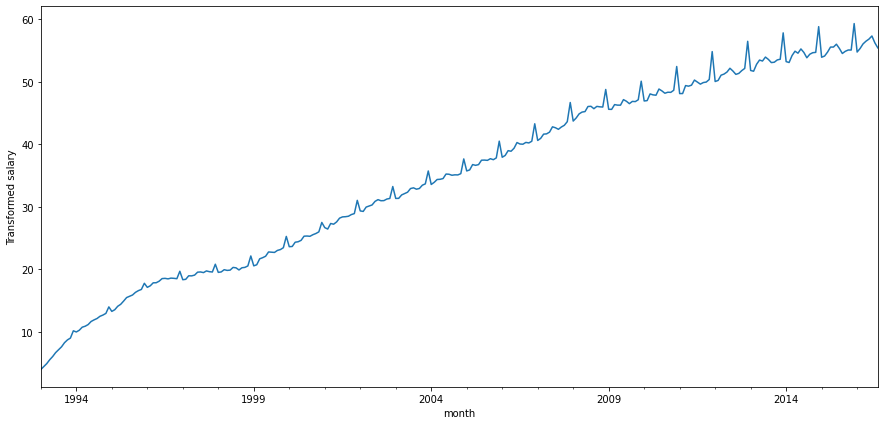

In [34]:
wag['salary_box'], lmbda = stats.boxcox(wag.WAG_C_M)
plt.figure(figsize = (15,7))
wag.salary_box.plot()
plt.ylabel(u'Transformed salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag.salary_box)[1])

Стационарность

Критерий Дики-Фуллера не отвергает гипотезу нестационарности и визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

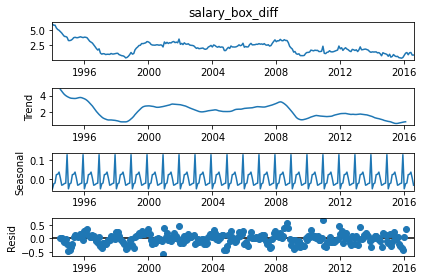

In [35]:
wag['salary_box_diff'] = wag.salary_box - wag.salary_box.shift(12)
plt.figure(figsize = (15,10))
sm.tsa.seasonal_decompose(wag.salary_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag.salary_box_diff[12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

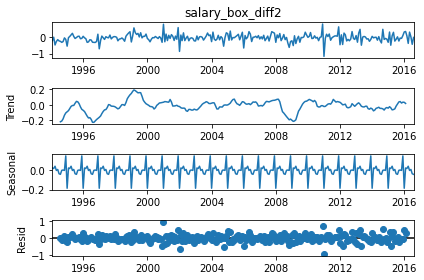

In [36]:
wag['salary_box_diff2'] = wag.salary_box_diff - wag.salary_box_diff.shift(1)
plt.figure(figsize = (15,10))
sm.tsa.seasonal_decompose(wag.salary_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wag.salary_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

Подбор модели

Посмотрим на ACF и PACF полученного ряда:

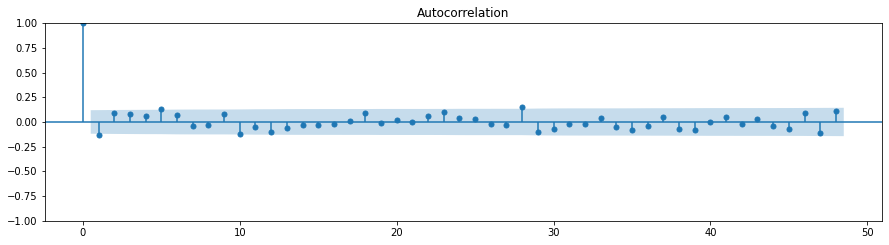

/home/nata/programs/jupyter/finalprojectenv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


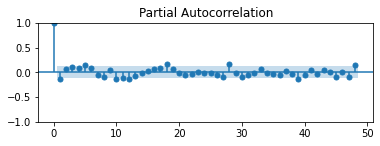

In [37]:
import pylab


plt.figure(figsize = (15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wag.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wag.salary_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=1, P=1, p=4

In [38]:
ps = range(0, 5)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [39]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

40

In [ ]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wag.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

In [ ]:
print(best_model.summary())

Её остатки:

In [ ]:
plt.figure(figsize = (15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

In [ ]:
wag['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize = (15,7))
wag.WAG_C_M.plot()
wag.model[13:].plot(color='r')
plt.ylabel('Wag salary')
pylab.show()

Прогноз

In [ ]:
wag2 = wag[['WAG_C_M']]
date_list = [datetime.datetime.strptime("01.03.2022", "%d.%m.%Y") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= wag2.columns)
wag2 = pd.concat([wag2, future])
wag2['forecast'] = invboxcox(best_model.predict(start=350, end=374), lmbda)

plt.figure(figsize = (15,7))
wag2.WAG_C_M.plot()
wag2.forecast.plot(color='r')
plt.ylabel('Wag salary')
pylab.show()